#Royal Cybers: End-to-End Machine Learning Pipeline for Personalized recommendations in Databricks 

## Load Dataset

In [0]:
# Load Dataset from S3 Bucket
cosmetic_store_data_path = "s3://e-commerce-pipeline-dataset/Cosmetic Store Website Data.csv"
reviews_data_path = "s3://e-commerce-pipeline-dataset/nyka_top_brands_cosmetics_product_reviews.csv"
product_mapping_path = "s3://e-commerce-pipeline-dataset/unique_product_id_pairings.csv"

cosmetic_df = spark.read.csv(cosmetic_store_data_path, header=True, inferSchema=True)
reviews_df = spark.read.csv(reviews_data_path, header=True, inferSchema=True)
mapping_df = spark.read.csv(product_mapping_path, header=True, inferSchema=True)

In [0]:
cosmetic_df.show(5)

+-------------------+----------+----------+-------------------+-------------+--------+-----+---------+--------------------+
|         event_time|event_type|product_id|        category_id|category_code|   brand|price|  user_id|        user_session|
+-------------------+----------+----------+-------------------+-------------+--------+-----+---------+--------------------+
|2020-01-01 00:00:00|      view|   5809910|1602943681873052386|         NULL| grattol| 5.24|595414620|4adb70bb-edbd-498...|
|2020-01-01 00:00:09|      view|   5812943|1487580012121948301|         NULL|kinetics| 3.97|595414640|c8c5205d-be43-4f1...|
|2020-01-01 00:00:19|      view|   5798924|1783999068867920626|         NULL|  zinger| 3.97|595412617|46a5010f-bd69-4fb...|
|2020-01-01 00:00:24|      view|   5793052|1487580005754995573|         NULL|    NULL| 4.92|420652863|546f6af3-a517-475...|
|2020-01-01 00:00:25|      view|   5899926|2115334439910245200|         NULL|    NULL| 3.92|484071203|cff70ddf-529e-4b0...|
+-------

In [0]:
reviews_df.show(5)

+----------+----------+---------+--------------------+--------------------+--------------+-------------------+-------------+----------+--------+--------------+--------------------+----+-----+--------------+--------------------+------------+--------------------+
|product_id|brand_name|review_id|        review_title|         review_text|        author|        review_date|review_rating|is_a_buyer|pro_user|  review_label|       product_title| mrp|price|product_rating|product_rating_count|product_tags|         product_url|
+----------+----------+---------+--------------------+--------------------+--------------+-------------------+-------------+----------+--------+--------------+--------------------+----+-----+--------------+--------------------+------------+--------------------+
|    781070|      Olay| 16752142|Worth buying 50g one|Works as it claim...| Ashton Dsouza|2021-01-23 15:17:18|          5.0|      True|   False|Verified Buyer|Olay Ultra Lightw...|1999| 1599|           4.1|        

In [0]:
mapping_df.show(5)

+-----------------+------------------+
|product_id_events|product_id_reviews|
+-----------------+------------------+
|            11719|            209281|
|            15161|           2645330|
|            16686|           3445855|
|            27658|           4749403|
|            34768|            995305|
+-----------------+------------------+
only showing top 5 rows



%md
## Initial Data Cleaning

In [0]:
# Drop Duplicates
cosmetic_df = cosmetic_df.dropDuplicates()
reviews_df = reviews_df.dropDuplicates()
mapping_df = mapping_df.dropDuplicates()

In [0]:
# Standardizing column names
cosmetic_df = cosmetic_df.withColumnRenamed("product_id", "cosmeticProductId") \
                         .withColumnRenamed("price", "cosmetic_price") 

reviews_df = reviews_df.withColumnRenamed("product_id", "reviewProductId") \
                       .withColumnRenamed("price", "review_price")

mapping_df = mapping_df.withColumnRenamed("product_id_events", "cosmeticProductId") \
                       .withColumnRenamed("product_id_reviews", "reviewProductId")

In [0]:
# Drop unnecessary columns and fill missing values
cosmetic_df = cosmetic_df.filter(cosmetic_df['cosmetic_price'] > 0)

mapping_df = mapping_df.na.drop()

In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import re

def clean_text(text):
    if text:
        text = text.lower()
        text = text.replace('\n', ' ').replace('\t', ' ').replace('\r', ' ')
        text = re.sub(r'[^a-zA-Z0-9\s/.]', '', text)  
        return text.strip()
    return text  

# Register UDF
clean_text_udf = udf(clean_text, StringType())

reviews_df = reviews_df.drop("product_tags")
reviews_df = reviews_df.fillna({
    'review_text': 'No review', 
    'brand_name': 'Unknown', 
    'review_label': 'No Label',
    'product_title': 'Unknown Title'
})

# Clean review_title and review_text
reviews_df = reviews_df.withColumn("review_title_clean", clean_text_udf(reviews_df["review_title"]))
reviews_df = reviews_df.withColumn("review_text_clean", clean_text_udf(reviews_df["review_text"]))

reviews_df.select("review_title", "review_title_clean", "review_text", "review_text_clean").show(5)

+------------------+------------------+--------------------+--------------------+
|      review_title|review_title_clean|         review_text|   review_text_clean|
+------------------+------------------+--------------------+--------------------+
|Invisible & Smooth| invisible  smooth|Wore these when I...|wore these when i...|
|              Nice|              nice|Works as it claim...|works as it claim...|
|             Great|             great|It Won't let your...|it wont let your ...|
|          Easy fix|          easy fix|This is one easy ...|this is one easy ...|
|        Give a try|        give a try|This is my first ...|this is my first ...|
+------------------+------------------+--------------------+--------------------+
only showing top 5 rows



In [0]:
# Filtering our multi classificaiton 
valid_events = ["view", "cart", "remove_from_cart", "purchase"]
cosmetic_df = cosmetic_df.filter(cosmetic_df.event_type.isin(valid_events))

cosmetic_df.groupBy("event_type").count().show()

+----------------+-------+
|      event_type|  count|
+----------------+-------+
|        purchase| 263570|
|            view|2032076|
|            cart|1126995|
|remove_from_cart| 609461|
+----------------+-------+



In [0]:
cosmetic_df.show(5)

+-------------------+----------+-----------------+-------------------+-------------+--------+--------------+---------+--------------------+
|         event_time|event_type|cosmeticProductId|        category_id|category_code|   brand|cosmetic_price|  user_id|        user_session|
+-------------------+----------+-----------------+-------------------+-------------+--------+--------------+---------+--------------------+
|2020-01-01 00:00:19|      view|          5798924|1783999068867920626|         NULL|  zinger|          3.97|595412617|46a5010f-bd69-4fb...|
|2020-01-01 00:00:25|      view|          5899926|2115334439910245200|         NULL|    NULL|          3.92|484071203|cff70ddf-529e-4b0...|
|2020-01-01 00:00:24|      view|          5793052|1487580005754995573|         NULL|    NULL|          4.92|420652863|546f6af3-a517-475...|
|2020-01-01 00:00:09|      view|          5812943|1487580012121948301|         NULL|kinetics|          3.97|595414640|c8c5205d-be43-4f1...|
|2020-01-01 00:00:00

In [0]:
reviews_df.show(5)

+---------------+--------------+---------+------------------+--------------------+-----------------+-------------------+-------------+----------+--------+--------------+--------------------+---+------------+--------------+--------------------+--------------------+------------------+--------------------+
|reviewProductId|    brand_name|review_id|      review_title|         review_text|           author|        review_date|review_rating|is_a_buyer|pro_user|  review_label|       product_title|mrp|review_price|product_rating|product_rating_count|         product_url|review_title_clean|   review_text_clean|
+---------------+--------------+---------+------------------+--------------------+-----------------+-------------------+-------------+----------+--------+--------------+--------------------+---+------------+--------------+--------------------+--------------------+------------------+--------------------+
|         785729|Nykaa Naturals| 27389259|Invisible & Smooth|Wore these when I...|   

In [0]:
mapping_df.show(5)

+-----------------+---------------+
|cosmeticProductId|reviewProductId|
+-----------------+---------------+
|            34768|         995305|
|            15161|        2645330|
|            16686|        3445855|
|            19162|        3494214|
|            11719|         209281|
+-----------------+---------------+
only showing top 5 rows



## Manage Delta Tables

In [0]:
cosmetic_delta_path = "/mnt/delta/cosmetic_store_data"
reviews_delta_path = "/mnt/delta/product_reviews"
mapping_delta_path = "/mnt/delta/product_mapping"

In [0]:
# Convert each cleaned DataFrame to Delta format
cosmetic_df.write.format("delta").mode("overwrite").save(cosmetic_delta_path)
reviews_df.write.format("delta").mode("overwrite").option("overwriteSchema", "true").save(reviews_delta_path)
mapping_df.write.format("delta").mode("overwrite").save(mapping_delta_path)


In [0]:
# Load Delta tables directly from paths
cosmetic_df = spark.read.format("delta").load(cosmetic_delta_path)
reviews_df = spark.read.format("delta").load(reviews_delta_path)
mapping_df = spark.read.format("delta").load(mapping_delta_path)


## Data Transformation

In [0]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.sql.functions import mean, stddev, col
from pyspark.sql.types import DoubleType, IntegerType

### Transform Cosmetic Data (Structured Interaction Data)

In [0]:
# Encode `event_type` column for interactions (structured data)
indexer = StringIndexer(inputCol="event_type", outputCol="event_type_index")
cosmetic_df = indexer.fit(cosmetic_df).transform(cosmetic_df)

# Scale `cosmetic_price` column
assembler = VectorAssembler(inputCols=["cosmetic_price"], outputCol="price_vec")
cosmetic_df = assembler.transform(cosmetic_df)

scaler = StandardScaler(inputCol="price_vec", outputCol="price_scaled")
cosmetic_df = scaler.fit(cosmetic_df).transform(cosmetic_df)

### Transform Reviews Data with Bert Tokenizer (Unstructured Sentiment Data)

In [0]:
from transformers import BertTokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch

# Load a pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load tokenizer and model for sentiment analysis
tokenizer = AutoTokenizer.from_pretrained("dipawidia/xlnet-base-cased-product-review-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("dipawidia/xlnet-base-cased-product-review-sentiment-analysis")

# Define a function for sentiment prediction
def get_sentiment(review):
    if not review:
        return "Neutral"  # Default sentiment for empty reviews
    # Tokenize the input text
    inputs = tokenizer(review, return_tensors="pt", truncation=True, padding=True, max_length=128)
    # Get model outputs
    outputs = model(**inputs)
    logits = outputs.logits
    # Convert logits to probabilities
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    # Get the predicted label
    predicted_class = torch.argmax(probabilities, dim=1).item()
    sentiment_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
    return sentiment_map[predicted_class]

# Register the function as a UDF
get_sentiment_udf = udf(get_sentiment, StringType())

# Apply the UDF to the DataFrame
reviews_df = reviews_df.withColumn("sentiment", get_sentiment_udf(reviews_df["review_text_clean"]))

# Display results
reviews_df.select("review_text_clean", "sentiment").show(5)

+--------------------+---------+
|   review_text_clean|sentiment|
+--------------------+---------+
|wore these when i...| Negative|
|works as it claim...| Negative|
|it wont let your ...| Negative|
|this is one easy ...|  Neutral|
|this is my first ...|  Neutral|
+--------------------+---------+
only showing top 5 rows



In [0]:
# Cast numerical columns to appropriate types
reviews_df = reviews_df.withColumn("mrp", reviews_df["mrp"].cast(DoubleType())) \
    .withColumn("review_price", reviews_df["review_price"].cast(DoubleType())) \
    .withColumn("product_rating", reviews_df["product_rating"].cast(DoubleType())) \
    .withColumn("product_rating_count", reviews_df["product_rating_count"].cast(IntegerType()))

### Transform Mapping Data

In [0]:
# Cast columns to IntegerType in `mapping_df`
mapping_df = mapping_df.withColumn("cosmeticProductId", mapping_df["cosmeticProductId"].cast(IntegerType()))
mapping_df = mapping_df.withColumn("reviewProductId", mapping_df["reviewProductId"].cast(IntegerType()))

# Calculate mean and standard deviation for filtering outliers
stats = mapping_df.select(
    mean("reviewProductId").alias("mean_reviews"),
    stddev("reviewProductId").alias("stddev_reviews")
).collect()[0]

mean_reviews = stats["mean_reviews"]
stddev_reviews = stats["stddev_reviews"]

# Filter out outliers beyond 3 standard deviations
mapping_df = mapping_df.filter(
    (col("reviewProductId") > mean_reviews - 3 * stddev_reviews) &
    (col("reviewProductId") < mean_reviews + 3 * stddev_reviews)
)

# Scale `cosmeticProductId` and `reviewProductId` in `mapping_df`
assembler = VectorAssembler(inputCols=["cosmeticProductId", "reviewProductId"], outputCol="mapping_features_vec")
mapping_df = assembler.transform(mapping_df)

scaler = StandardScaler(inputCol="mapping_features_vec", outputCol="mapping_scaled_features")
mapping_df = scaler.fit(mapping_df).transform(mapping_df)

## Combine the Transformed Data

In [0]:
# Join `cosmetic_df` and `mapping_df` on `cosmeticProductId`
cosmetic_mapped_df = cosmetic_df.join(mapping_df, cosmetic_df["cosmeticProductId"] == mapping_df["cosmeticProductId"], "inner")

# Join the result with `reviews_df` on `reviewProductId`
combined_df = cosmetic_mapped_df.join(reviews_df, cosmetic_mapped_df["reviewProductId"] == reviews_df["reviewProductId"], "inner")

# Drop the duplicate one
combined_df = combined_df.drop("cosmeticProductId", "reviewProductId", "event_type", "brand_name", "sentiment")

In [0]:
# Save combined_df to Delta table
combined_data_path = "/mnt/delta/combined_cleaned_data"
combined_df.write.format("delta").mode("overwrite").option("overwriteSchema", "true").save(combined_data_path)

In [0]:
combined_df.printSchema()

root
 |-- event_time: timestamp (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- cosmetic_price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)
 |-- event_type_index: double (nullable = false)
 |-- price_vec: vector (nullable = true)
 |-- price_scaled: vector (nullable = true)
 |-- mapping_features_vec: vector (nullable = true)
 |-- mapping_scaled_features: vector (nullable = true)
 |-- review_id: integer (nullable = true)
 |-- review_title: string (nullable = true)
 |-- review_text: string (nullable = true)
 |-- author: string (nullable = true)
 |-- review_date: string (nullable = true)
 |-- review_rating: string (nullable = true)
 |-- is_a_buyer: string (nullable = true)
 |-- pro_user: string (nullable = true)
 |-- review_label: string (nullable = true)
 |-- product_title: string (nullable = true)
 |-- mrp: double (nullable = t

In [0]:
combined_df.show(5)

+-------------------+-------------------+-------------+------+--------------+---------+--------------------+----------------+---------+--------------------+--------------------+-----------------------+---------+--------------------+--------------------+---------------+-------------------+-------------+----------+--------+--------------------+--------------------+------+------------+--------------+--------------------+--------------------+--------------------+--------------------+
|         event_time|        category_id|category_code| brand|cosmetic_price|  user_id|        user_session|event_type_index|price_vec|        price_scaled|mapping_features_vec|mapping_scaled_features|review_id|        review_title|         review_text|         author|        review_date|review_rating|is_a_buyer|pro_user|        review_label|       product_title|   mrp|review_price|product_rating|product_rating_count|         product_url|  review_title_clean|   review_text_clean|
+-------------------+---------

## Exploratory Data Analysis

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation


In [0]:
# Summary statistics for numeric columns
combined_df.describe().show()

+-------+--------------------+--------------------+-------+-----------------+-------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+-------------------+-----------------+------------------+-----------------+--------------------+--------------------+------------------+--------------------+
|summary|         category_id|       category_code|  brand|   cosmetic_price|            user_id|        user_session|  event_type_index|           review_id|        review_title|         review_text|              author|         review_date|       review_rating|          is_a_buyer|          pro_user|        review_label|      product_title|              mrp|      review_price|   product_rating|product_rating_count|         product_url|review_title_clean|   review_text_clean|
+-------+--------------------+------

In [0]:
# Calculate specific statistics
combined_df.select("cosmetic_price", "review_price", "product_rating", "product_rating_count").describe().show()


+-------+-----------------+------------------+-----------------+--------------------+
|summary|   cosmetic_price|      review_price|   product_rating|product_rating_count|
+-------+-----------------+------------------+-----------------+--------------------+
|  count|          3889948|           3888207|          3889090|             3889437|
|   mean|6.803305887368991|442.46164671788307|4.424189591911089|   7192.410815755597|
| stddev|9.864445453158451| 249.8975158777531|14.43695063627094|   12825.31601903842|
|    min|             0.32|               5.0|              1.5|                   1|
|    max|           184.13|            2947.0|           1103.0|               98477|
+-------+-----------------+------------------+-----------------+--------------------+



In [0]:
# Average product rating by brand
combined_df.groupBy("brand").agg({"product_rating": "avg"}).withColumnRenamed("avg(product_rating)", "average_rating").show()

+---------+------------------+
|    brand|    average_rating|
+---------+------------------+
|depilflax| 4.799597264684023|
|   ardell| 4.351248172565016|
|     NULL| 4.497763329848901|
|   masura|  4.26233221041742|
|    konad| 4.318323677948051|
|  bluesky|  4.16570341300966|
|   runail|4.1651109199730705|
|   entity| 4.449711237941344|
| ingarden|  4.07247776886427|
|   gehwol|               4.0|
|     enas|3.9420638805715624|
|      opi|               4.0|
|      cnd| 4.010292253304722|
|   sophin|11.066700796359376|
+---------+------------------+



### Distribution of Price

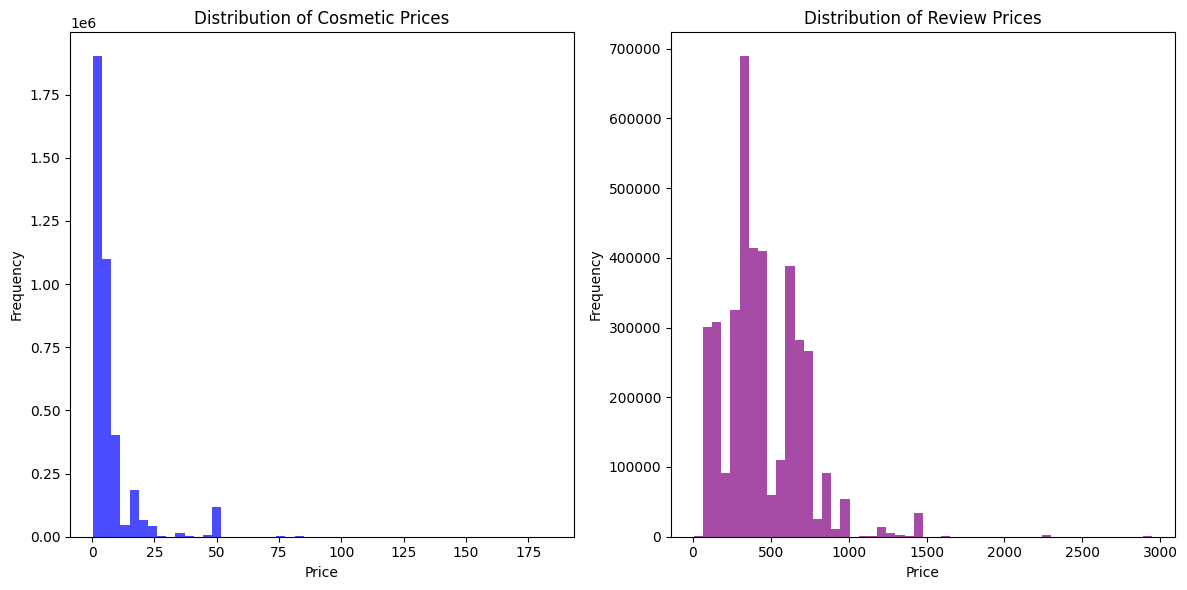

In [0]:
# Distribution of cosmetic_price and review_price to understand pricing across products

cosmetic_price_data = combined_df.select("cosmetic_price").rdd.flatMap(lambda x: x).collect()
review_price_data = combined_df.select("review_price").rdd.flatMap(lambda x: x).filter(lambda x: x is not None).collect()

plt.figure(figsize=(12, 6))

# Histogram for cosmetic_price
plt.subplot(1, 2, 1)
plt.hist(cosmetic_price_data, bins=50, color="blue", alpha=0.7)
plt.title("Distribution of Cosmetic Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")

# Histogram for review_price
plt.subplot(1, 2, 2)
plt.hist(review_price_data, bins=50, color="purple", alpha=0.7)
plt.title("Distribution of Review Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


### Product Rating Distribution

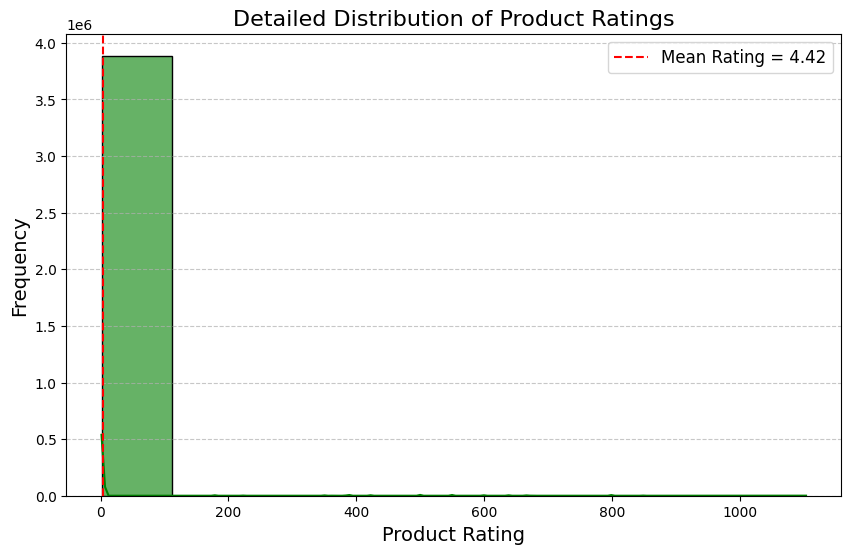

In [0]:
# Collect rating data and filter out None values
rating_data = combined_df.select("product_rating").rdd.flatMap(lambda x: x).filter(lambda x: x is not None).collect()

plt.figure(figsize=(10, 6))
sns.histplot(rating_data, bins=10, kde=True, color="green", alpha=0.6)

# Mean rating calculation
mean_rating = np.mean(rating_data)
plt.axvline(mean_rating, color="red", linestyle="--", label=f"Mean Rating = {mean_rating:.2f}")

plt.title("Detailed Distribution of Product Ratings", fontsize=16)
plt.xlabel("Product Rating", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

### Customer Engagement Patterns Over Time

+----------+------+
|event_date| count|
+----------+------+
|2020-01-01| 75966|
|2020-01-02| 99253|
|2020-01-03|103953|
|2020-01-04|100535|
|2020-01-05| 97520|
|2020-01-06| 99593|
|2020-01-07|104468|
|2020-01-08|111154|
|2020-01-09|123578|
|2020-01-10| 83693|
|2020-01-11|130860|
|2020-01-12|139827|
|2020-01-13|152676|
|2020-01-14|124106|
|2020-01-15|139207|
|2020-01-16|170937|
|2020-01-17|131742|
|2020-01-18|102404|
|2020-01-19|141684|
|2020-01-20|168794|
+----------+------+
only showing top 20 rows



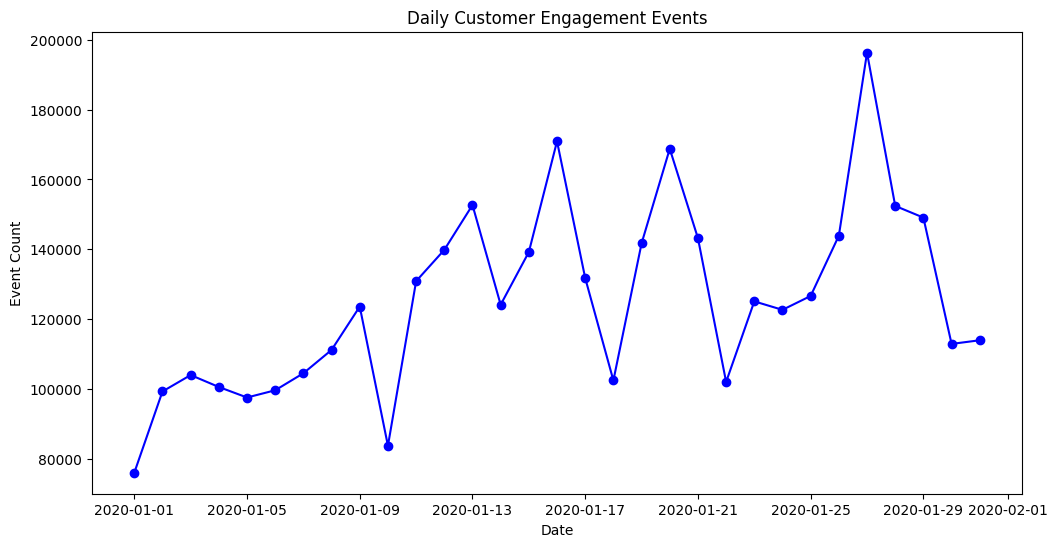

In [0]:
combined_df = combined_df.withColumn("event_date", col("event_time").cast("date"))

# Count engagement events per day
daily_engagement = combined_df.groupBy("event_date").count().orderBy("event_date")
daily_engagement.show()

date_data = daily_engagement.select("event_date").rdd.flatMap(lambda x: x).collect()
engagement_data = daily_engagement.select("count").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(12, 6))
plt.plot(date_data, engagement_data, color="blue", marker="o")
plt.title("Daily Customer Engagement Events")
plt.xlabel("Date")
plt.ylabel("Event Count")
plt.show()


### Distribution of Customer Engagement Levels (Event Types)

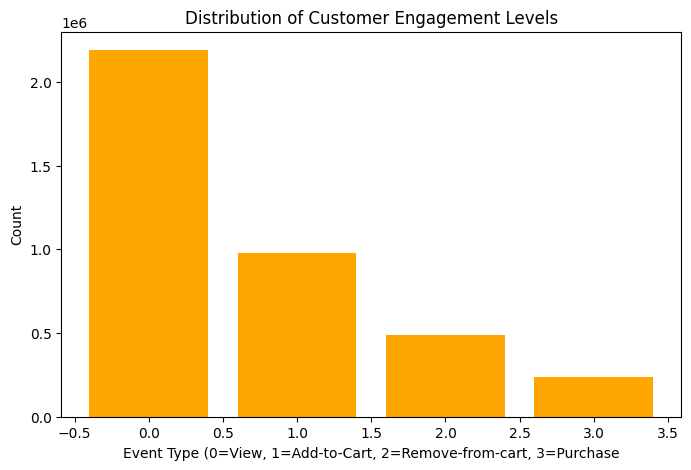

In [0]:
event_data = combined_df.groupBy("event_type_index").count().collect()
event_labels = [row["event_type_index"] for row in event_data]
event_counts = [row["count"] for row in event_data]

plt.figure(figsize=(8, 5))
plt.bar(event_labels, event_counts, color="orange")
plt.title("Distribution of Customer Engagement Levels")
plt.xlabel("Event Type (0=View, 1=Add-to-Cart, 2=Remove-from-cart, 3=Purchase")
plt.ylabel("Count")
plt.show()

### Sentimental Analysis

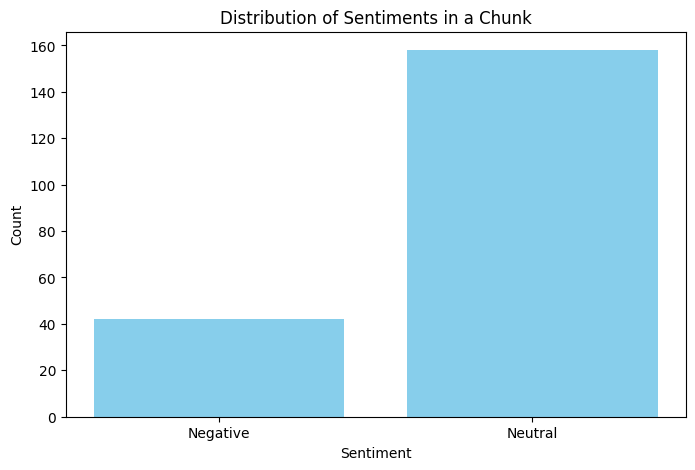

In [0]:
chunk = reviews_df.limit(200) 

chunk_counts = chunk.groupBy("sentiment").count().toPandas()

plt.figure(figsize=(8, 5))
plt.bar(chunk_counts["sentiment"], chunk_counts["count"], color="skyblue")
plt.title("Distribution of Sentiments in a Chunk")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


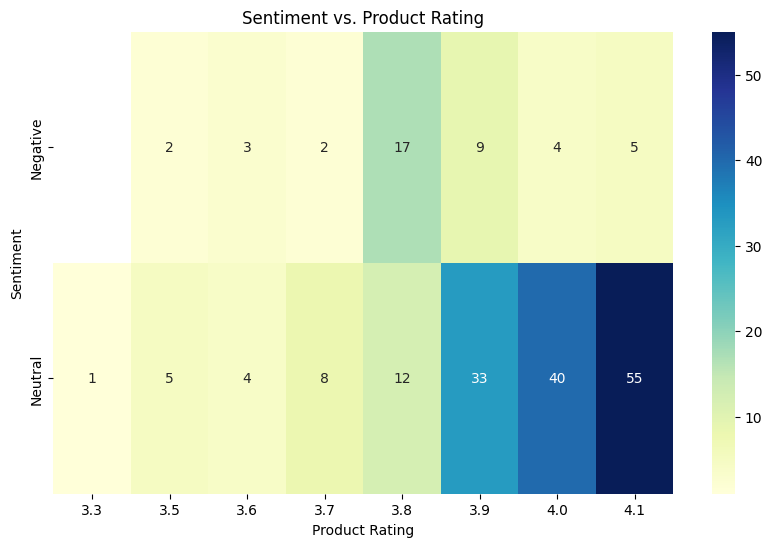

In [0]:
# Sentiment vs. Rating Distribution
rating_sentiment = chunk.groupBy("sentiment", "product_rating").count().toPandas()

pivot_data = rating_sentiment.pivot(index="sentiment", columns="product_rating", values="count")

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_data, annot=True, fmt="g", cmap="YlGnBu", cbar=True) 
plt.title("Sentiment vs. Product Rating")
plt.xlabel("Product Rating")
plt.ylabel("Sentiment")
plt.show()

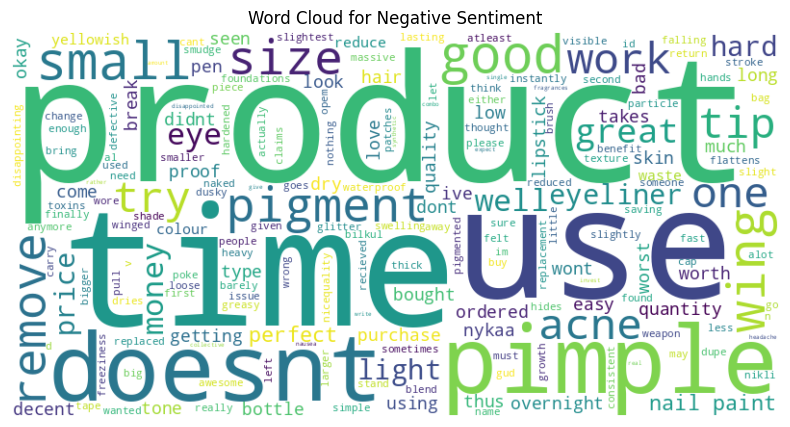

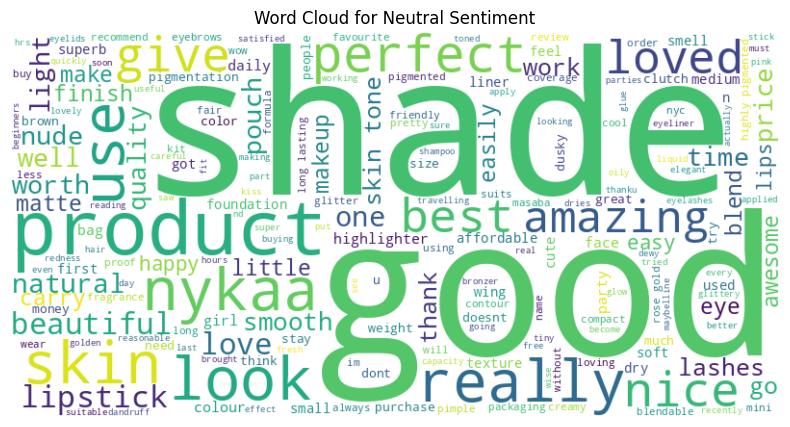

In [0]:
from wordcloud import WordCloud

# Word clouds for each sentiment
for sentiment_label in chunk.select("sentiment").distinct().collect():
    sentiment_label = sentiment_label["sentiment"]
    text = " ".join(chunk.filter(chunk["sentiment"] == sentiment_label).select("review_text_clean").rdd.flatMap(lambda x: x).collect())

    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for {sentiment_label} Sentiment")
    plt.show()

/root/.ipykernel/167672/command-2432490846381817-3304699915:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  top_brands = sentiment_brand.groupby("brand_name").sum()["count"].sort_values(ascending=False).head(10).index


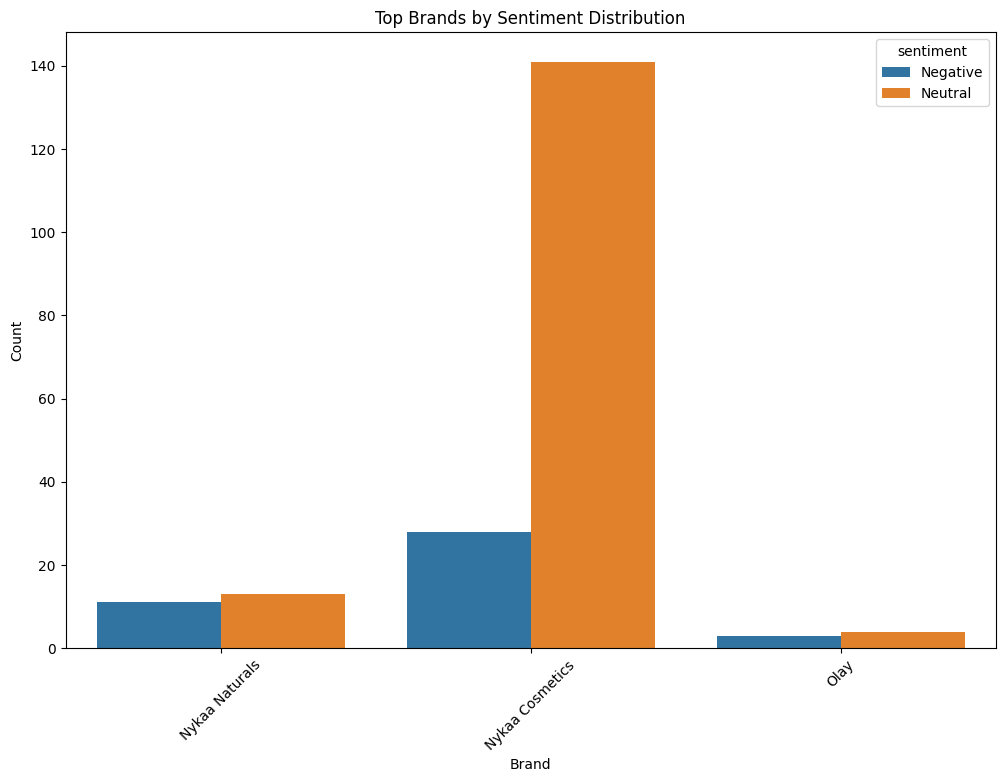

In [0]:
# Sentiment by Brand
sentiment_brand = chunk.groupBy("sentiment", "brand_name").count().toPandas()

# Top brands with sentiment
top_brands = sentiment_brand.groupby("brand_name").sum()["count"].sort_values(ascending=False).head(10).index
filtered_data = sentiment_brand[sentiment_brand["brand_name"].isin(top_brands)]

plt.figure(figsize=(12, 8))
sns.barplot(data=filtered_data, x="brand_name", y="count", hue="sentiment")
plt.title("Top Brands by Sentiment Distribution")
plt.xlabel("Brand")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

#### Time Series Analysis of Ratings

+------------------+------------------+
|review_date_parsed|        avg_rating|
+------------------+------------------+
|              NULL| 527.1788617886178|
|        2013-05-20|               4.0|
|        2013-10-07|3.8000000000000003|
|        2014-04-16|4.1000000000000005|
|        2014-04-29|               4.0|
|        2014-05-23|               4.1|
|        2014-05-28|               4.1|
|        2014-05-31|               4.0|
|        2014-06-03|4.1000000000000005|
|        2014-06-04|3.9897727272727277|
|        2014-06-06|3.8000000000000003|
|        2014-06-11|               4.1|
|        2014-06-21|               4.1|
|        2014-06-24|               4.1|
|        2014-06-30|               4.1|
|        2014-07-01| 4.100000000000001|
|        2014-07-08|3.8000000000000003|
|        2014-07-09|               4.1|
|        2014-07-14|               4.1|
|        2014-07-17|               4.1|
+------------------+------------------+
only showing top 20 rows



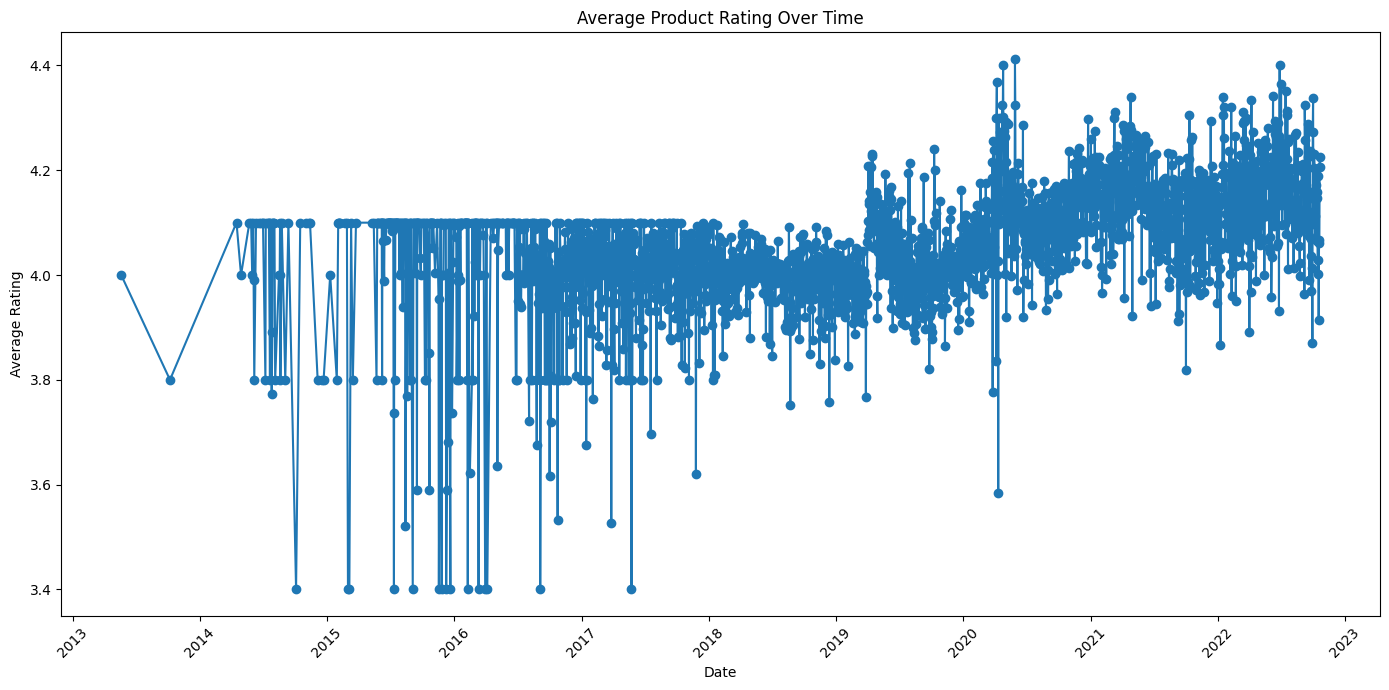

In [0]:
from pyspark.sql import functions as F

# Extract date from review_date
combined_df = combined_df.withColumn(
    "review_date_parsed",
    F.to_timestamp("review_date", "yyyy-MM-dd HH:mm:ss").cast("date")
)

# Proceed with grouping and aggregation
daily_ratings = combined_df.groupBy("review_date_parsed").agg(
    F.avg("product_rating").alias("avg_rating")
).orderBy("review_date_parsed")

daily_ratings.show()

# Plot time series
date_data = [row['review_date_parsed'] for row in daily_ratings.collect()]
rating_data = [row['avg_rating'] for row in daily_ratings.collect()]

plt.figure(figsize=(14, 7))
plt.plot(date_data, rating_data, marker='o', linestyle='-')
plt.title('Average Product Rating Over Time')
plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### User Behavior Analysis

+---------+-----+
|  user_id|count|
+---------+-----+
|379181470|20229|
|602284233|13827|
|526596989|13260|
|598055880|11887|
|508506759|10167|
|549941895| 9836|
|595792732| 9393|
|269803542| 9360|
|596854010| 9143|
| 53613286| 9045|
+---------+-----+
only showing top 10 rows



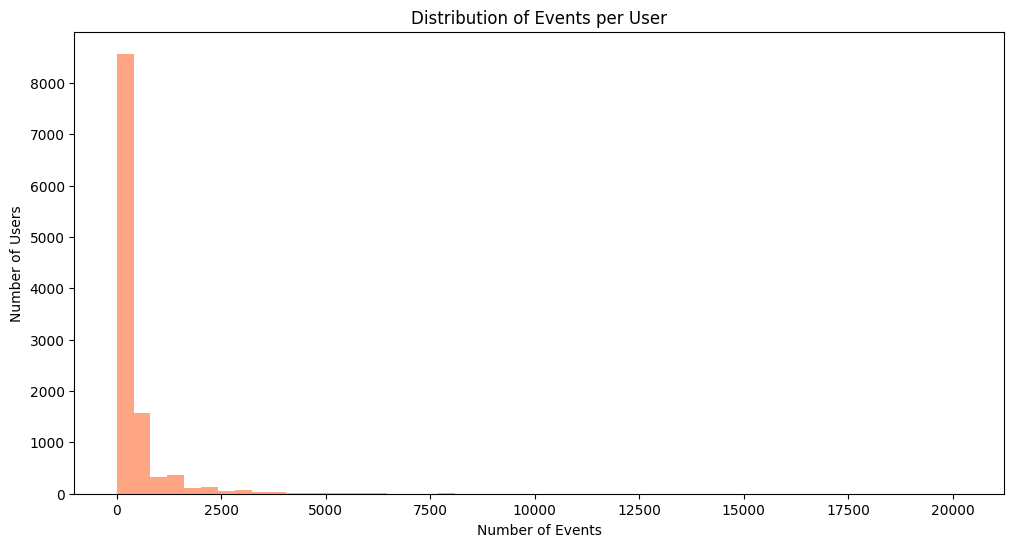

In [0]:
# Number of events per user
user_events = combined_df.groupBy("user_id").count().orderBy(F.desc("count"))
user_events.show(10)

# Plot distribution of events per user
event_counts = user_events.select("count").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(12, 6))
plt.hist(event_counts, bins=50, color="coral", alpha=0.7)
plt.title('Distribution of Events per User')
plt.xlabel('Number of Events')
plt.ylabel('Number of Users')
plt.show()

#### Distribution of Product Ratings by Brand

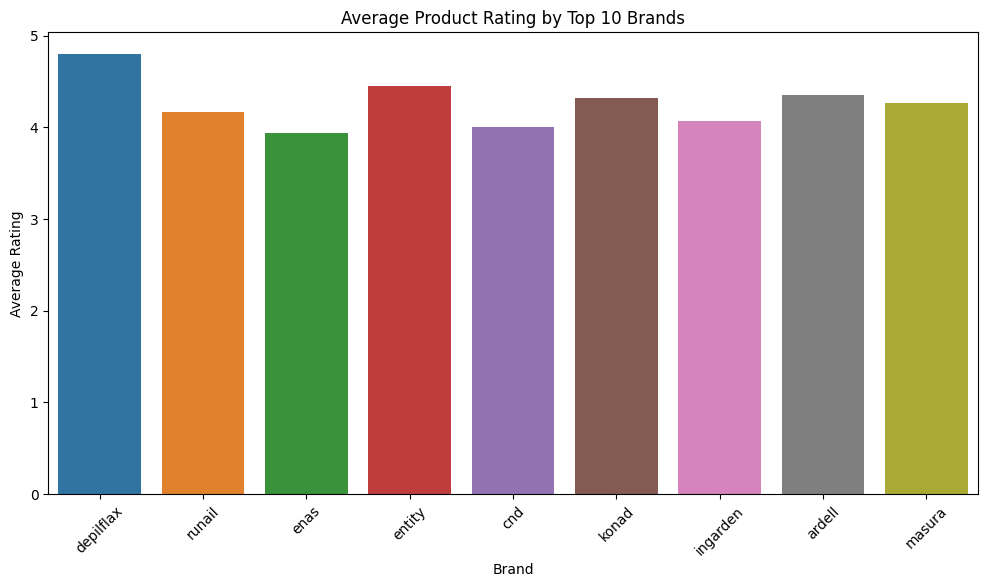

In [0]:
# Average rating per brand
brand_ratings = combined_df.groupBy("brand").agg(
    F.avg("product_rating").alias("avg_rating"),
    F.count("product_rating").alias("rating_count")
)

top_brands_ratings = brand_ratings.orderBy(F.desc("rating_count")).limit(10)
top_brands_pd = top_brands_ratings.toPandas()

# Bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='brand', y='avg_rating', data=top_brands_pd)
plt.xticks(rotation=45)
plt.title('Average Product Rating by Top 10 Brands')
plt.xlabel('Brand')
plt.ylabel('Average Rating')
plt.show()

#### Convert Review Ratings to Numeric and Analyze

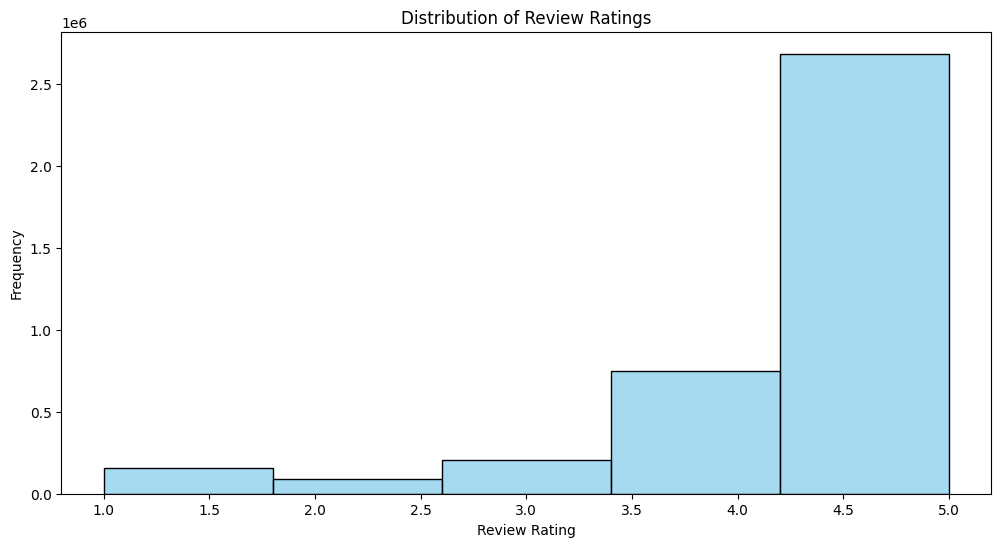

In [0]:
# Convert review_rating to numeric
combined_df = combined_df.withColumn("review_rating_num", F.col("review_rating").cast("double"))

# Drop rows where conversion failed
combined_df = combined_df.na.drop(subset=["review_rating_num"])

# Histogram of review ratings
review_rating_data = combined_df.select("review_rating_num").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(12, 6))
sns.histplot(review_rating_data, bins=5, kde=False, color="skyblue")
plt.title('Distribution of Review Ratings')
plt.xlabel('Review Rating')
plt.ylabel('Frequency')
plt.show()

#### Session-Level Analysis

+--------------------+-----+
|        user_session|count|
+--------------------+-----+
|dc659625-aa39-470...|11191|
|b2528609-d6e9-4ec...| 9385|
|0542c088-0256-469...| 9030|
|b678bd37-d894-4ac...| 8536|
|4e13419f-074d-4ae...| 7777|
|db069885-d8c6-40b...| 7695|
|7ad04b55-bf1f-4f4...| 7617|
|0c002789-f20f-4ac...| 7448|
|2534bba9-1488-41e...| 7370|
|d0836902-0046-4df...| 6740|
+--------------------+-----+
only showing top 10 rows



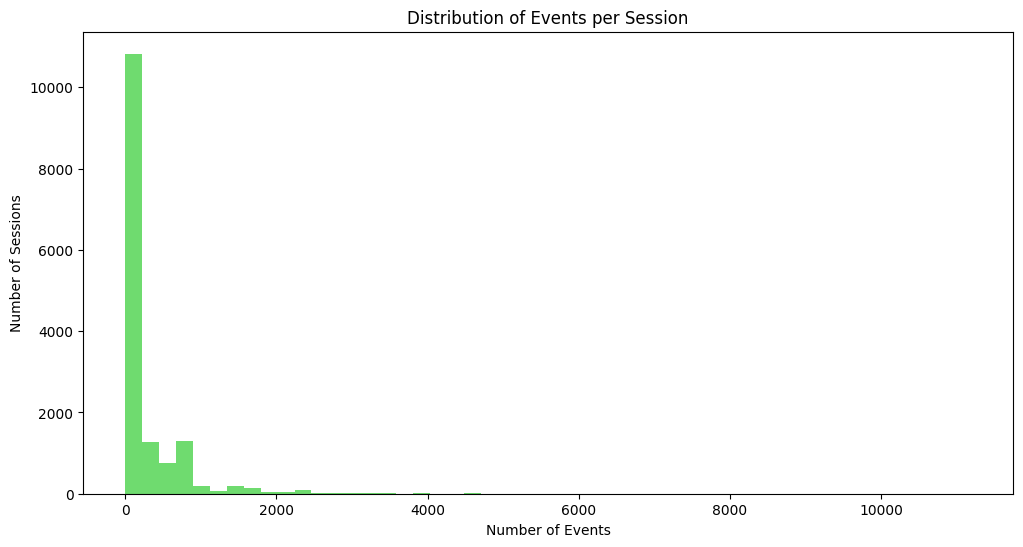

In [0]:
# Number of events per session
session_events = combined_df.groupBy("user_session").count().orderBy(F.desc("count"))
session_events.show(10)

# Distribution plot
session_counts = session_events.select("count").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(12, 6))
plt.hist(session_counts, bins=50, color="limegreen", alpha=0.7)
plt.title('Distribution of Events per Session')
plt.xlabel('Number of Events')
plt.ylabel('Number of Sessions')
plt.show()